This project uses articles from TechCrunch from 2010 to 2016 to conduct Natural Languages Processing analysis.

### Import the packages

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import pickle
from collections import Counter
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import sent_tokenize
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
from tqdm import tqdm
%matplotlib inline

In [3]:
pd.options.display.max_columns = 100

### Import the data

In [4]:
raw = pd.read_csv('techcrunch_posts.csv')

In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39115 entries, 0 to 39114
Data columns (total 11 columns):
authors     38815 non-null object
category    38393 non-null object
content     39061 non-null object
date        39115 non-null object
id          39115 non-null int64
img_src     39115 non-null object
section     39115 non-null object
tags        34148 non-null object
title       39115 non-null object
topics      5604 non-null object
url         39115 non-null object
dtypes: int64(1), object(10)
memory usage: 3.3+ MB


In [17]:
startups = df[df['category'] == 'Startups']
startups.head()

,authors,category,content,date,id,img_src,section,tags,title,topics,url
0,Dale Chang,Startups,\n\nTech investing isn’t what it used to be — ...,2016-10-15,1401293,https://tctechcrunch2011.files.wordpress.com/2...,startups/,data,How startups can use data to grow smarter,NaN,https://techcrunch.com/2016/10/15/how-startups...
4,Megan Rose Dickey,Startups,"Uber, the ridesharing behemoth that recently b...",2016-10-13,1401633,https://tctechcrunch2011.files.wordpress.com/2...,startups/,lawsuits,Uber hits another roadblock,uber,https://techcrunch.com/2016/10/13/uber-hits-an...
5,Ajay Chopra,Startups,"\n\nDespite what some politicians say, no coun...",2016-10-13,1399039,https://tctechcrunch2011.files.wordpress.com/2...,startups/,partnerships,From the distributed workforce to the partnere...,NaN,https://techcrunch.com/2016/10/13/from-the-dis...
14,John Rampton,Startups,\n\nThe JOBS Act was signed into law by Presid...,2016-10-12,1399031,https://tctechcrunch2011.files.wordpress.com/2...,startups/,"securities-and-exchange-commission,equity-crow...",What regulation crowdfunding in the JOBS Act m...,american-jobs-act,https://techcrunch.com/2016/10/12/what-regulat...
111,Anthony Ha,Startups,Remote Year should be a pretty appealing idea ...,2016-10-11,1399984,https://tctechcrunch2011.files.wordpress.com/2...,startups/,"remote-work,highland-capital-partners",Remote Year raises $12 million to combine remo...,NaN,https://techcrunch.com/2016/10/11/remote-year-...


In [18]:
# Drop the articles without contents

df = startups[pd.notnull(startups['content'])]

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2967 entries, 0 to 39113
Data columns (total 11 columns):
authors     2932 non-null object
category    2967 non-null object
content     2967 non-null object
date        2967 non-null object
id          2967 non-null int64
img_src     2967 non-null object
section     2967 non-null object
tags        2517 non-null object
title       2967 non-null object
topics      213 non-null object
url         2967 non-null object
dtypes: int64(1), object(10)
memory usage: 278.2+ KB


In [20]:
# Fill null values

df[['category']].fillna('none', inplace = True)

//anaconda/lib/python3.5/site-packages/pandas/core/frame.py:2762: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [21]:
df[df['category'] == 'Startups']['content']

0        \n\nTech investing isn’t what it used to be — ...
4        Uber, the ridesharing behemoth that recently b...
5        \n\nDespite what some politicians say, no coun...
14       \n\nThe JOBS Act was signed into law by Presid...
111      Remote Year should be a pretty appealing idea ...
118      It’s easy to feel like you’re missing out on a...
120      During a contentious election filled with accu...
178      \n\nThere are three types of science fiction (...
325      \n\nMany startup companies begin with either a...
329      Closing a Series A is notoriously hard — so mu...
334      The criminal justice system in our country is ...
428      A startup called Heek wants to make building w...
430      \n\nWhile most founders want to make a boatloa...
442      \n\nFor startup CEOs, tough economic periods a...
544      \nF\nThey also pair participating startups wit...
547      Interface design collaboration tool Figma is l...
548      Be honest: Have you ever spent an entire day w.

### Exploratory Data Analysis

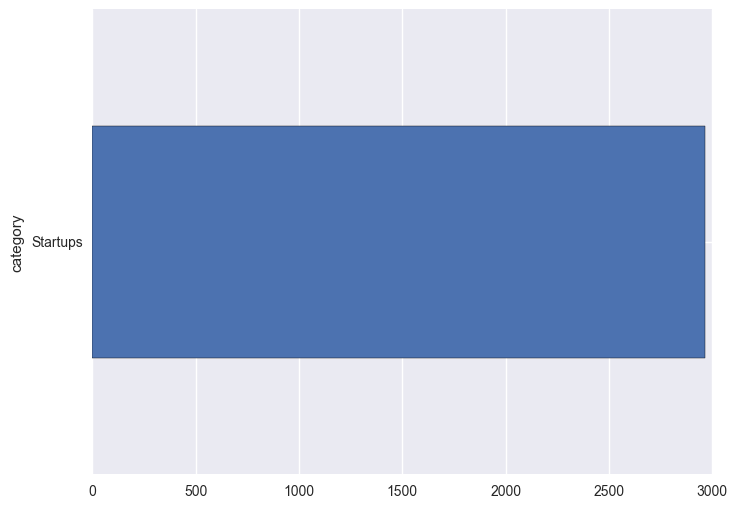

In [22]:
# Plot the categories

categories = df.groupby('category')['id'].count()
categories = categories.sort_values(ascending = False)[:20]

categories.plot(kind = 'barh', figsize=(8, 6))

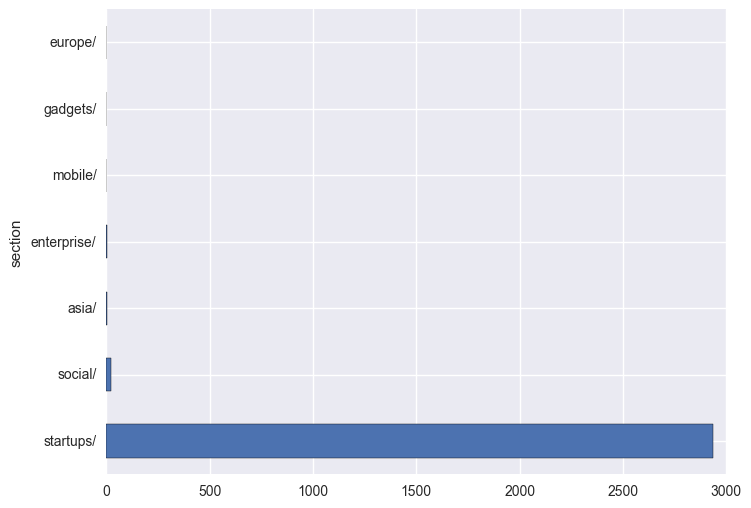

In [23]:
# Plot the sections

sections = df.groupby('section')['id'].count()
sections = sections.sort_values(ascending = False)[:20]

sections.plot(kind = 'barh', figsize=(8, 6))

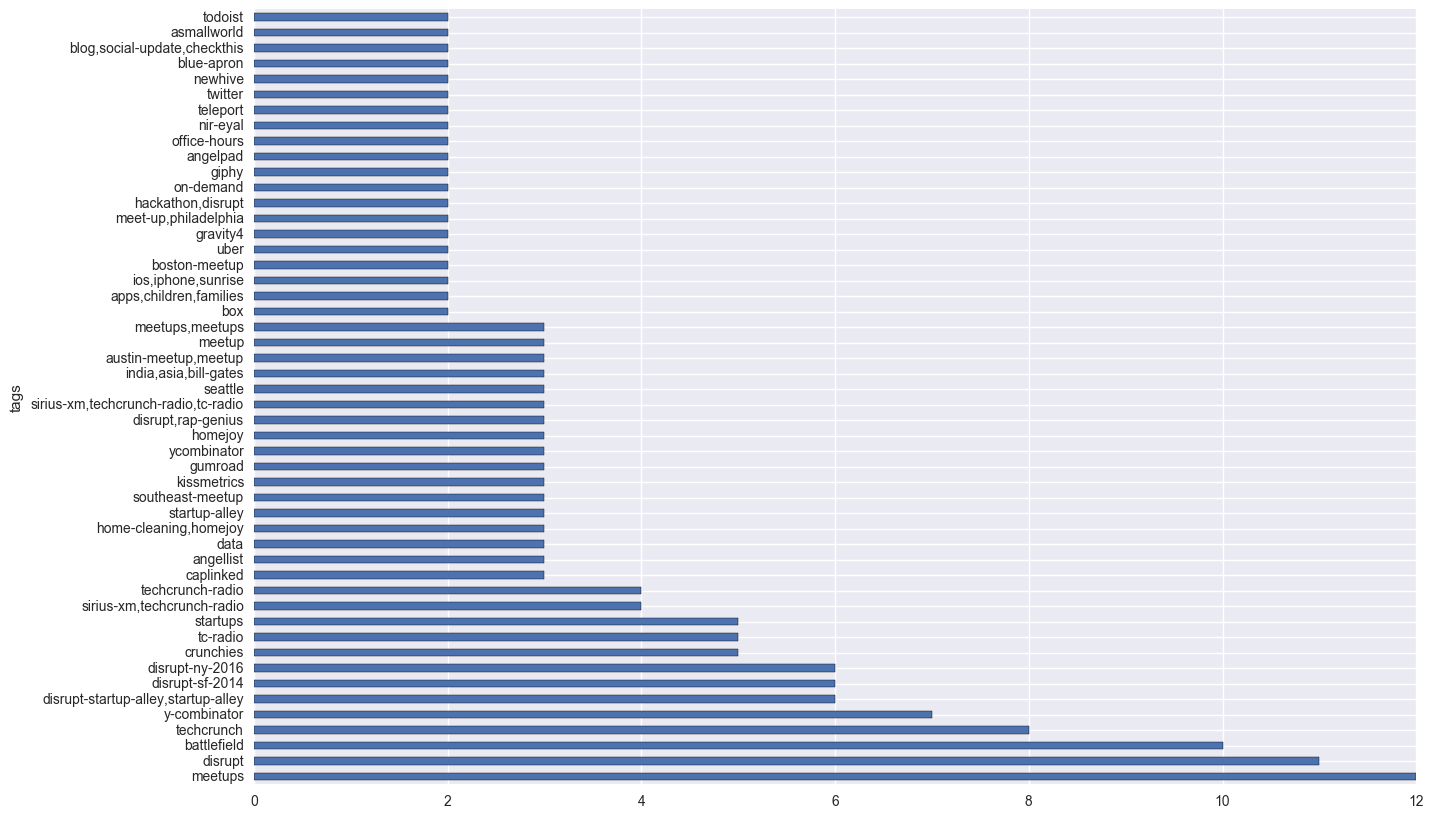

In [28]:
# Plot the tags

tags = df.groupby('tags')['id'].count()
tags = tags.sort_values(ascending = False)[:50]

tags.plot(kind = 'barh', figsize=(15, 10))

#### WordCloud

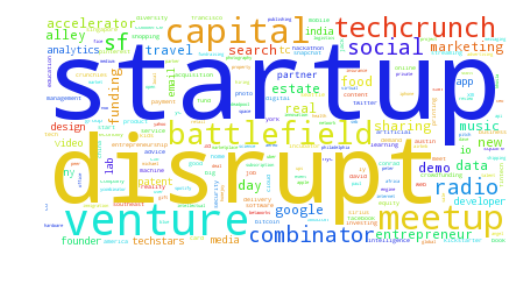

In [29]:
#Word Cloud for tags(without word size weights)
list_of_tags = [str(t) for t in df['tags']]
list_of_tags_combined = ' '.join(list_of_tags)
list_of_tags_combined = list_of_tags_combined.replace('nan', '')

cloud_text = list_of_tags_combined

wordcloud = WordCloud(stopwords=STOPWORDS, background_color = 'white').generate(cloud_text)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Process the article content by removing punctuation, convert words to lower case, remove stop words and stemming.

In [30]:
def process_content(data):
    
    # Keep only the words, remove punctuations
    formatted_content = re.sub("[^a-zA-Z]", " ", data)
    
    # Convert all words to lower case and split into a list
    words = formatted_content.lower().split()
    
    # List of stop words
    stop = stopwords.words('english')
    
    # Produce a list of clean words that does not appear in stop words
    clean_words = [w for w in words if w not in stop]
    
    # Stemming
    stemmer = nltk.stem.porter.PorterStemmer()
    stem_clean_words = [stemmer.stem(w) for w in clean_words if w not in stop]

    return " ".join(stem_clean_words)

In [31]:
# Create a list of clean contents, later uses pickle file


startups_complete_clean_content = []
for article in df['content']:
    startups_complete_clean_content.append(process_content(article))


In [14]:
# Save complete list of contents into pickle file

# pd.to_pickle(complete_clean_content, 'content.pkl')

In [15]:
# contents = pd.read_pickle('content.pkl')

In [32]:
contents = startups_complete_clean_content

#### Create a TD-IDF Matrix

In [33]:
# TF-IDF Matrix for top 1000 words, excluding words that appear in fewer than 5 articles and more than 90% of articles

tfidf = TfidfVectorizer(ngram_range=(1,1), min_df=5, max_df = 0.9, max_features=1000, stop_words='english')
x_tfidf = tfidf.fit_transform(contents)

In [34]:
print('Matrix')
x_back_tfidf = x_tfidf.toarray()
print(x_back_tfidf)

Matrix
[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.10522157  0.          0.        ]
 [ 0.          0.05233467  0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.0437699  ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


In [35]:
pd.DataFrame(x_back_tfidf, columns=tfidf.get_feature_names()).head()

,abil,abl,acceler,accept,access,accord,account,achiev,acquir,acquisit,act,action,activ,actual,ad,add,addit,address,adopt,advanc,advantag,advertis,advic,afford,age,agenc,aggreg,ago,ahead,aim,airbnb,algorithm,alley,allow,alon,alreadi,altern,alway,amaz,amazon,america,american,analysi,analyt,analyz,android,angel,announc,annual,anoth,...,use,user,usual,valley,valu,valuabl,valuat,variou,vc,ventur,version,vertic,video,view,virtual,vision,visit,visitor,visual,voic,wait,walk,wall,want,watch,way,web,websit,week,went,wide,win,window,winner,women,word,work,worker,world,worth,write,wrong,wrote,yahoo,yc,ye,year,york,young,youtub
0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.028917,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.048902,0.034356,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.034173,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.028571,...,0.055420,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.074281,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020274,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.031040,0.034107,0.000000,0.045896,0.000000,0.000000,0.00000,0.044634,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.036858,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.075088,0.0,0.0,0.0,0.034831,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.101476,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.105222,0.0,0.0
2,0.0,0.052335,0.0,0.0,0.026885,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.038660,0.0,0.000000,0.000000,0.027747,0.000000,0.0,0.040045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.030239,0.0,0.000000,0.090255,0.0,0.0,0.022595,0.0,0.046059,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.120676,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.037299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017844,0.000000,0.055290,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.065012,0.043946,0.071229,0.034905,0.0,0.0,0.0,0.0,0.0,0.0,0.033445,0.000000,0.0,0.0
3,0.0,0.026965,0.0,0.0,0.013852,0.000000,0.031827,0.000000,0.016813,0.018876,0.04145,0.000000,0.0,0.000000,0.000000,0.000000,0.027652,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.032898,0.000000,0.0,0.0,0.046567,0.0,0.000000,0.019582,0.046491,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.025913,...,0.058641,0.0,0.0,0.0,0.000000,0.0,0.0,0.018832,0.000000,0.012176,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009194,0.018392,0.018992,0.0,0.0,0.0,0.0,0.0,0.019265,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.008616,0.000000,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.045789,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.056619,0.0,0.000000,0.084497,0.0,0.0,0.042307,0.0,0.000000,0.000000,0.000000,0.07684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.048243,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.056489,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.121729,0.000000,0.044457,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.250494,0.000000,0.0,0.0


#### PCA

In [36]:
# PCA using SVD - 500 components

pca_reducer = PCA(n_components = 500)
pca_reduced_X = pca_reducer.fit_transform(x_back_tfidf)

sum(pca_reducer.explained_variance_ratio_)

0.84862543699089499

In [37]:
# PCA using Truncated SVD - 500 components

reducer_svd = TruncatedSVD(n_components = 500)
reduced_X_svd = reducer_svd.fit_transform(x_back_tfidf)

sum(reducer_svd.explained_variance_ratio_)

0.84979003002393427

In [38]:
# PCA using SVD - 200 components

pca_reducer_200 = PCA(n_components = 200)
pca_reduced_X_200 = pca_reducer_200.fit_transform(x_back_tfidf)

sum(pca_reducer_200.explained_variance_ratio_)

0.57417078558501189

In [39]:
# PCA using Truncated SVD - 200 components

reducer_svd_200 = TruncatedSVD(n_components = 200)
reduced_X_svd_200 = reducer_svd_200.fit_transform(x_back_tfidf)

sum(reducer_svd_200.explained_variance_ratio_)

0.57578546989463519

#### Clustering - Kmeans

In [83]:
# K-means with truncated SVD - 500 components

num_clusters = 10

km = KMeans(n_clusters=num_clusters)

%time km.fit(reduced_X_svd)

clusters = km.labels_.tolist()

CPU times: user 6.78 s, sys: 150 ms, total: 6.93 s
Wall time: 3.55 s


In [84]:
# RUN LATER 

Counter(clusters)

Counter({0: 72,
         1: 347,
         2: 87,
         3: 124,
         4: 88,
         5: 881,
         6: 420,
         7: 555,
         8: 32,
         9: 361})

In [85]:
# RUN LATER

%time silhouette_score(pca_reduced_X, clusters)

CPU times: user 683 ms, sys: 50 ms, total: 733 ms
Wall time: 410 ms


0.021427843745030144

In [86]:
%time silhouette_score(reduced_X_svd, clusters)

CPU times: user 525 ms, sys: 37.5 ms, total: 563 ms
Wall time: 311 ms


0.021424716694327633

#### Clustering - Agglomerative Hierarchical

In [77]:
num_cluster = 15

ah = AgglomerativeClustering(n_clusters = num_cluster, affinity = 'euclidean', linkage = 'ward')

%time ah.fit(reduced_X_svd)

clusters_ah = ah.labels_.tolist()

CPU times: user 2.59 s, sys: 23.4 ms, total: 2.61 s
Wall time: 2.62 s


In [78]:
# RUN LATER

Counter(clusters_ah)

Counter({0: 701,
         1: 1031,
         2: 254,
         3: 276,
         4: 130,
         5: 181,
         6: 26,
         7: 54,
         8: 65,
         9: 34,
         10: 80,
         11: 31,
         12: 63,
         13: 28,
         14: 13})

In [79]:
# RUN LATER

%time silhouette_score(pca_reduced_X, clusters_ah)

CPU times: user 679 ms, sys: 55.1 ms, total: 734 ms
Wall time: 413 ms


0.018402453915580722

In [80]:
# RUN LATER

%time silhouette_score(pca_reduced_X, clusters_ah)

CPU times: user 656 ms, sys: 40.3 ms, total: 697 ms
Wall time: 371 ms


0.018402453915580722

In [82]:
# Plot the number of cluster vs silhouette score

def plot_silouette(data, num):
    for n in range(num):
        print (n)

In [ ]:
plot_silouette(df, )

#### Clustering - DBSCAN

#### Clustering - Mean Shift

#### Clustering - Spectral Clustering

#### Topic Modeling - Create a Count Matrix

In [17]:
# Count Matrix for top 1000 words, excluding words that appear in fewer than 5 articles and more than 90% of articles

cv = CountVectorizer(ngram_range=(1,1), min_df=5, max_df = 0.9, max_features=1000, stop_words='english')

# Fit the vectorizer with article content
cv.fit(contents)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=1000, min_df=5,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [18]:
# Create the term-document matrix
# Transpose it so the terms are the rows

counts = cv.transform(contents).transpose()

In [ ]:
# Map matrix rows to words (tokens)

id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [ ]:
# Convert to gensim

corpus = matutils.Sparse2Corpus(counts)

In [19]:
print('Matrix')
x_back_cv = x_cv.toarray()
print(x_back_cv)

Matrix
[[0 0 0 ..., 0 0 0]
 [1 1 0 ..., 0 0 0]
 [2 1 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [20]:
pd.DataFrame(x_back_cv, columns=cv.get_feature_names()).head()

,abil,abl,acceler,accept,access,accord,account,achiev,acquir,acquisit,act,action,activ,actual,ad,add,addit,address,adopt,advanc,advantag,advertis,afford,age,agenc,aggreg,ago,ahead,aim,air,alert,algorithm,allow,alon,alreadi,altern,alway,amazon,america,american,analyt,android,angel,announc,anoth,answer,anyon,anyth,api,app,...,upgrad,upload,usag,use,user,usual,valley,valu,valuat,variou,vc,ventur,version,video,view,virtual,vision,visit,visual,voic,vr,wait,wall,want,watch,way,wearabl,web,websit,week,went,whatev,whatsapp,wide,wider,win,window,women,word,work,world,worth,write,wrote,yahoo,ye,year,york,young,youtub
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,2,0,0,5,4,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,7,0,0,0
2,2,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,2,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5,0,0,0
4,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0


#### Topic Modeling

#### Word2Vec

#### Recommender

Recommend articles with others that lay in the same cluster.

In [130]:
km.labels_[0]

17

In [132]:
# Function to return a list of article index that's in the same cluster

def rec_articles(index):  
    rec = []
    c = km.labels_[index]
    n = 0
    for item in km.labels_:
        if item == c:
            rec.append(n)
        n += 1
    return rec

In [138]:
rec_articles(1)

[1, 100, 649, 700, 745, 959, 962, 973]

#### Sentiment of each article

In [55]:
# Sentiment of articles

def article_sentiment(data):
    d = OrderedDict()
    n = 1
    article_sentiment = OrderedDict()
    for item in data:
        d[n] = TextBlob(item).sentiment
        n += 1
    return d

In [56]:
df_sentiments = article_sentiment(df['content'])

In [66]:
df_sentiments

OrderedDict([(1,
              Sentiment(polarity=0.1521342756570029, subjectivity=0.5428042874633782)),
             (2,
              Sentiment(polarity=0.11882332643202209, subjectivity=0.4306267253278124)),
             (3,
              Sentiment(polarity=0.12646656065023412, subjectivity=0.5562402450157552)),
             (4,
              Sentiment(polarity=0.10013408521303258, subjectivity=0.5248053467000836)),
             (5,
              Sentiment(polarity=0.10025974025974027, subjectivity=0.39515151515151514)),
             (6,
              Sentiment(polarity=0.21134580617339233, subjectivity=0.45092779187606774)),
             (7,
              Sentiment(polarity=0.08636898815470241, subjectivity=0.44738555095697946)),
             (8,
              Sentiment(polarity=0.1275573192239859, subjectivity=0.3000881834215167)),
             (9,
              Sentiment(polarity=0.08790711346266902, subjectivity=0.5865196942974722)),
             (10,
              Sentiment(pol

In [40]:
# Sentence tokennizer

sentences = sent_tokenize(raw['content'][0])

In [41]:
# Word tokenizer

tokenizer = TreebankWordTokenizer()
tokenizer.tokenize(sentences[0])

['Tech',
 'investing',
 'isn’t',
 'what',
 'it',
 'used',
 'to',
 'be',
 '—',
 'even',
 'compared',
 'to',
 'six',
 'months',
 'ago',
 '.']